<div style = "font-family:Georgia;
              font-size:2.5vw;
              color:lightblue;
              font-style:bold;
              text-align:center;
              background:url('./Animations/Title Background.gif') no-repeat center;
              background-size:cover)">
              
     <br><br>
     Histograms of Oriented Gradients (HOG)
     <br><br><br>
     
</div>

<h1 style = "text-align:left">Introduction</h1>

As we saw with the ORB algorithm, we can use keypoints in images to do keypoint-based matching to detect objects in images. These type of algorithms work great when you want to detect objects that have a lot of consistent internal features that are not affected by the background. For example, these algorithms work well for facial detection because faces have a lot of consistent internal features that don’t get affected by the image background, such as the eyes, nose, and mouth. However, these type of algorithms don’t work so well when attempting to do more general object recognition, say for example, pedestrian detection in images. The reason is that people don’t have consistent internal features, like faces do, because the body shape and style of every person is different (see Fig. 1). This means that every person is going to have a different set of internal features, and so we need something that can more generally describe a person. 

<br>
<figure>
  <img src = "./Animations/pedestrians.jpeg" width = "100%" style = "border: thin silver solid; padding: 10px">
      <figcaption style = "text-align:left; font-style:italic">Fig. 1. - Pedestrians.</figcaption>
</figure> 
<br>

One option is to try to detect pedestrians by their contours instead.  Detecting objects in images by their contours (boundaries) is very challenging because we have to deal with the difficulties brought about by the contrast between the background and the foreground. For example, suppose you wanted to detect a pedestrian in an image that is walking in front of a white building and she is wearing a white coat and black pants (see Fig. 2). We can see in Fig. 2, that since the background of the image is mostly white, the black pants are going to have a very high contrast, but the coat, since it is white as well, is going to have very low contrast. In this case, detecting the edges of pants is going to be easy but detecting the edges of the coat is going to be very difficult. This is where **HOG** comes in. HOG stands for **Histograms of Oriented Gradients** and it was first introduced by Navneet Dalal and Bill Triggs in 2005.

<br>
<figure>
  <img src = "./Animations/woman.jpg" width = "100%" style = "border: thin silver solid; padding: 10px">
      <figcaption style = "text-align:left; font-style:italic">Fig. 2. - High and Low Contrast.</figcaption>
</figure> 
<br>

The HOG algorithm works by creating histograms of the distribution of gradient orientations in an image and then normalizing them in a very special way. This special normalization is what makes HOG so effective at detecting the edges of objects even in cases where the contrast is very low. These normalized histograms are put together into a feature vector, known as the HOG descriptor, that can be used to train a machine learning algorithm, such as a Support Vector Machine (SVM), to detect objects in images based on their boundaries (edges). Due to its great success and reliability, HOG has become one of the most widely used algorithms in computer vison for object detection.


In this notebook, you will learn:

* How the HOG algorithm works
* How to use OpenCV to create a HOG descriptor
* How to visualize the HOG descriptor. 

# The HOG Algorithm

As its name suggests, the HOG algorithm, is based on creating histograms from the orientation of image gradients. The HOG algorithm is implemented in a series of steps:

1. Given the image of particular object, set a detection window (region of interest) that covers the entire object in the image (see Fig. 3).

2. Calculate the magnitude and direction of the gradient for each individual pixel in the detection window.

3. Divide the detection window into connected *cells* of pixels, with all cells being of the same size (see Fig. 3). The size of the cells is a free parameter and it is usually chosen so as to match the scale of the features that want to be detected. For example, in a 64 x 128 pixel detection window, square cells 6 to 8 pixels wide are suitable for detecting human limbs.

4. Create a Histogram for each cell, by first grouping the gradient directions of all pixels in each cell into a particular number of orientation (angular) bins; and then adding up the gradient magnitudes of the gradients in each angular bin (see Fig. 3). The number of bins in the histogram is a free parameter and it is usually set to 9 angular bins.

5. Group adjacent cells into *blocks* (see Fig. 3). The number of cells in each block is a free parameter and all blocks must be of the same size. The distance between each block (known as the stride) is a free parameter but it is usually set to half the block size, in which case you will get overlapping blocks (*see video below*).  The HOG algorithm has been shown empirically to work better with overlapping blocks.

6. Use the cells contained within each block to normalize the cell histograms in that block (see Fig. 3). If you have overlapping blocks this means that most cells will be normalized with respect to different blocks (*see video below*). Therefore, the same cell may have several different normalizations.

7. Collect all the normalized histograms from all the blocks into a single feature vector called the HOG descriptor.

8. Use the resulting HOG descriptors from many images of the same type of object to train a machine learning algorithm, such as an SVM, to detect those type of objects in images. For example, you could use the HOG descriptors from many images of pedestrians to train an SVM to detect pedestrians in images. The training is done with both positive a negative examples of the object you want detect in the image.

9. Once the SVM has been trained, a sliding window approach is used to try to detect and locate objects in images.  Detecting an object in the image entails finding the part of the image that looks similar to the HOG pattern learned by the SVM.

<br>
<figure>
  <img src = "./Animations/HOG Diagram2.png" width = "100%" style = "border: thin silver solid; padding: 1px">
      <figcaption style = "text-align:left; font-style:italic">Fig. 3. - HOG Diagram.</figcaption>
</figure> 
<br>

<figure>
<video src = "./Animations/HOG Animation - Medium.mp4" width="100%" controls autoplay loop> </video>
<figcaption style = "text-align:left; font-style:italic">Vid. 1. - HOG Animation.</figcaption>
</figure> 

# Why The HOG Algorithm Works

As we learned above, HOG creates histograms by adding the magnitude of the gradients in particular orientations in localized portions of the image called *cells*.  By doing this we guarantee that stronger gradients will contribute more to the magnitude of their respective angular bin, while the effects of weak and randomly oriented gradients resulting from noise are minimized. In this manner the histograms tell us the dominant gradient orientation of each cell. 


### Dealing with contrast 

Now, the magnitude of the dominant orientation can vary widely due to variations in local illumination and the contrast between the background and the foreground.

To account for the background-foreground contrast differences, the HOG algorithm tries to detect edges locally.  In order to do this, it defines groups of cells, called **blocks**, and normalizes the histograms using this local group of cells. By normalizing locally, the HOG algorithm can detect the edges in each block very reliably; this is called **block normalization**.

In addition to using block normalization, the HOG algorithm also uses overlapping blocks to increase its performance. By using overlapping blocks, each cell contributes several independent components to the final HOG descriptor, where each component corresponds to a cell being normalized with respect to a different block. This may seem redundant but, it has been shown empirically that by normalizing each cell several times with respect to different local blocks, the performance of the HOG algorithm increases dramatically. 

### Loading Images and Importing Resources

The first step in building our HOG descriptor is to load the required packages into Python and to load our image. 

We start by using OpenCV to load an image of a triangle tile. Since, the `cv2.imread()` function loads images as BGR we will convert our image to RGB so we can display it with the correct colors. As usual we will convert our BGR image to Gray Scale for analysis.

The original image has shape:  (250, 250, 3)
The gray scale image has shape:  (250, 250)


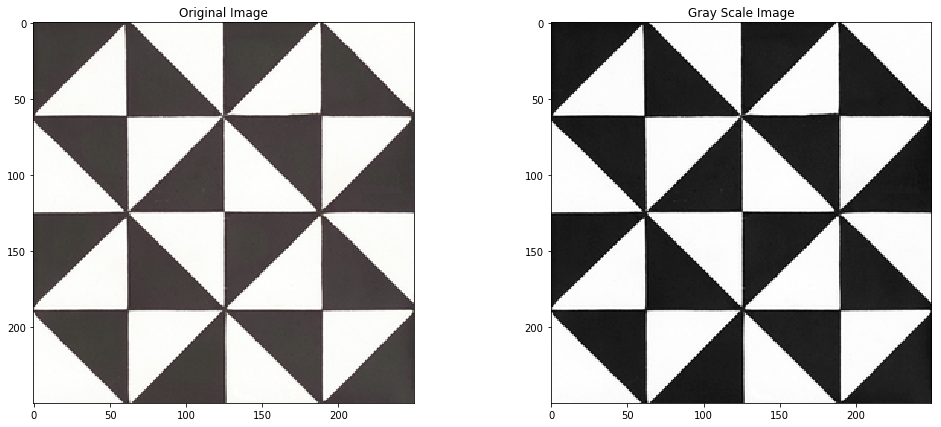

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Set the default figure size
plt.rcParams['figure.figsize'] = [17.0, 7.0]

# Load the image 
image = cv2.imread('./images/triangle_tile.jpeg')

# Convert the original image to RGB
original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the original image to gray scale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Print the shape of the original and gray scale images
print('The original image has shape: ', original_image.shape)
print('The gray scale image has shape: ', gray_image.shape)

# Display the images
plt.subplot(121)
plt.imshow(original_image)
plt.title('Original Image')
plt.subplot(122)
plt.imshow(gray_image, cmap='gray')
plt.title('Gray Scale Image')
plt.show()

# Creating The HOG Descriptor

We will be using OpenCV’s `HOGDescriptor` class to create the HOG descriptor. The parameters of the HOG descriptor are setup using the `HOGDescriptor()` function. The parameters of the `HOGDescriptor()` function and their default values are given below:

`cv2.HOGDescriptor(win_size = (64, 128),  
                  block_size = (16, 16),  
                  block_stride = (8, 8),  
                  cell_size = (8, 8),  
                  nbins = 9,  
                  win_sigma = DEFAULT_WIN_SIGMA,  
                  threshold_L2hys = 0.2,  
                  gamma_correction = true,  
                  nlevels = DEFAULT_NLEVELS)`

Parameters:

* **win_size** – *Size*  
Size of detection window in pixels (*width, height*). Defines the region of interest. Must be an integer multiple of cell size.


* **block_size** – *Size*  
Block size in pixels (*width, height*). Defines how many cells are in each block. Must be an integer multiple of cell size and it must be smaller than the detection window. The smaller the block the finer detail you will get.


* **block_stride** – *Size*  
Block stride in pixels (*horizontal, vertical*). It must be an integer multiple of cell size. The `block_stride` defines the distance between adjecent blocks, for example, 8 pixels horizontally and 8 pixels vertically. Longer `block_strides` makes the algorithm run faster (because less blocks are evaluated) but the algorithm may not perform as well.


* **cell_size** – *Size*  
Cell size in pixels (*width, height*). Determines the size fo your cell. The smaller the cell the finer detail you will get.


* **nbins** – *int*  
Number of bins for the histograms. Determines the number of angular bins used to make the histograms. With more bins you capture more gradient directions. HOG uses unsigned gradients, so the angular bins will have values between 0 and 180 degrees.


* **win_sigma** – *double*  
Gaussian smoothing window parameter. The performance of the HOG algorithm can be improved by smoothing the pixels near the edges of the blocks by applying a Gaussian spatial window to each pixel before computing the histograms.


* **threshold_L2hys** – *double*  
L2-Hys (Lowe-style clipped L2 norm) normalization method shrinkage. The L2-Hys method is used to normalize the blocks and it consists of an L2-norm followed by clipping and a renormalization. The clipping limits the maximum value of the descriptor vector for each block to have the value of the given threshold (0.2 by default). After the clipping the descriptor vector is renormalized as described in *IJCV*, 60(2):91-110, 2004.


* **gamma_correction** – *bool*  
Flag to specify whether the gamma correction preprocessing is required or not. Performing gamma correction slightly increases the performance of the HOG algorithm.


* **nlevels** – *int*  
Maximum number of detection window increases.

As we can see, the  `cv2.HOGDescriptor()`function supports a wide range of parameters. The first few arguments (`block_size, block_stride, cell_size`, and `nbins`) are probably the ones you are most likely to change. The other parameters can be safely left at their default values and you will get good results. 

In the code below, we will use the `cv2.HOGDescriptor()`function to set the cell size, block size, block stride, and the number of bins for the histograms of the HOG descriptor. We will then use `.compute(image)`method to compute the HOG descriptor (feature vector) for the given `image`. 

In [3]:
# Specify the parameters for our HOG descriptor

# Cell Size in pixels (width, height). Must be smaller than the size of the detection window
# and must be chosen so that the resulting Block Size is smaller than the detection window.
cell_size = (6, 6)

# Number of cells per block in each direction (x, y). Must be chosen so that the resulting
# Block Size is smaller than the detection window
num_cells_per_block = (2, 2)

# Block Size in pixels (width, height). Must be an integer multiple of Cell Size.
# The Block Size must be smaller than the detection window
block_size = (num_cells_per_block[0] * cell_size[0],
              num_cells_per_block[1] * cell_size[1])

# Calculate the number of cells that fit in our image in the x and y directions
x_cells = gray_image.shape[1] // cell_size[0]
y_cells = gray_image.shape[0] // cell_size[1]

# Horizontal distance between blocks in units of Cell Size. Must be an integer and it must
# be set such that (x_cells - num_cells_per_block[0]) / h_stride = integer.
h_stride = 1

# Vertical distance between blocks in units of Cell Size. Must be an integer and it must
# be set such that (y_cells - num_cells_per_block[1]) / v_stride = integer.
v_stride = 1

# Block Stride in pixels (horizantal, vertical). Must be an integer multiple of Cell Size
block_stride = (cell_size[0] * h_stride, cell_size[1] * v_stride)

# Number of gradient orientation bins
num_bins = 9        


# Specify the size of the detection window (Region of Interest) in pixels (width, height).
# It must be an integer multiple of Cell Size and it must cover the entire image. Because
# the detection window must be an integer multiple of cell size, depending on the size of
# your cells, the resulting detection window might be slightly smaller than the image.
# This is perfectly ok.
win_size = (x_cells * cell_size[0] , y_cells * cell_size[1])

# Print the shape of the gray scale image for reference
print('\nThe gray scale image has shape: ', gray_image.shape)
print()

# Print the parameters of our HOG descriptor
print('HOG Descriptor Parameters:\n')
print('Window Size:', win_size)
print('Cell Size:', cell_size)
print('Block Size:', block_size)
print('Block Stride:', block_stride)
print('Number of Bins:', num_bins)
print()

# Set the parameters of the HOG descriptor using the variables defined above
hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)

# Compute the HOG Descriptor for the gray scale image
hog_descriptor = hog.compute(gray_image)


The gray scale image has shape:  (250, 250)

HOG Descriptor Parameters:

Window Size: (246, 246)
Cell Size: (6, 6)
Block Size: (12, 12)
Block Stride: (6, 6)
Number of Bins: 9



# Number of Elements In The HOG Descriptor

The resulting HOG Descriptor (feature vector), contains the normalized histograms from all cells from all blocks in the detection window concatenated in one long vector. Therefore, the size of the HOG feature vector will be given by the total number of blocks in the detection window, multiplied by the number of cells per block, times the number of orientation bins:

<span class="mathquill">
\begin{equation}
\mbox{total_elements} = (\mbox{total_number_of_blocks})\mbox{ } \times \mbox{ } (\mbox{number_cells_per_block})\mbox{ } \times \mbox{ } (\mbox{number_of_bins})
\end{equation}
</span>

If we don’t have overlapping blocks (*i.e.* the `block_stride`equals the `block_size`), the total number of blocks can be easily calculated by dividing the size of the detection window by the block size. However, in the general case we have to take into account the fact that we have overlapping blocks. To find the total number of blocks in the general case (*i.e.* for any `block_stride` and `block_size`), we can use the formula given below:

<span class="mathquill">
\begin{equation}
\mbox{Total}_i = \left( \frac{\mbox{block_size}_i}{\mbox{block_stride}_i} \right)\left( \frac{\mbox{window_size}_i}{\mbox{block_size}_i} \right) - \left [\left( \frac{\mbox{block_size}_i}{\mbox{block_stride}_i} \right) - 1 \right]; \mbox{  for  } i = x,y
\end{equation}
</span>

Where <span class="mathquill">Total$_x$</span>, is the total number of blocks along the width of the detection window, and <span class="mathquill">Total$_y$</span>, is the total number of blocks along the height of the detection window. This formula for <span class="mathquill">Total$_x$</span> and <span class="mathquill">Total$_y$</span>, takes into account the extra blocks that result from overlapping. After calculating <span class="mathquill">Total$_x$</span> and <span class="mathquill">Total$_y$</span>, we can get the total number of blocks in the detection window by multiplying <span class="mathquill">Total$_x$  $\times$ Total$_y$</span>. The above formula can be simplified considerably because the `block_size`, `block_stride`, and `window_size`are all defined in terms of the `cell_size`. By making all the appropriate substitutions and cancelations the above formula reduces to:

<span class="mathquill">
\begin{equation}
\mbox{Total}_i = \left(\frac{\mbox{cells}_i - \mbox{num_cells_per_block}_i}{N_i}\right) + 1\mbox{  }; \mbox{  for  } i = x,y
\end{equation}
</span>

Where <span class="mathquill">cells$_x$</span> is the total number of cells along the width of the detection window, and <span class="mathquill">cells$_y$</span>, is the total number of cells along the height of the detection window. And <span class="mathquill">$N_x$</span> is the horizontal block stride in units of `cell_size` and <span class="mathquill">$N_y$</span> is the vertical block stride in units of `cell_size`. 

Let's calculate what the number of elements for the HOG feature vector should be and check that it matches the shape of the HOG Descriptor calculated above.

In [4]:
# Calculate the total number of blocks along the width of the detection window
tot_bx = np.uint32(((x_cells - num_cells_per_block[0]) / h_stride) + 1)

# Calculate the total number of blocks along the height of the detection window
tot_by = np.uint32(((y_cells - num_cells_per_block[1]) / v_stride) + 1)

# Calculate the total number of elements in the feature vector
tot_els = (tot_bx) * (tot_by) * num_cells_per_block[0] * num_cells_per_block[1] * num_bins

# Print the total number of elements the HOG feature vector should have
print('\nThe total number of elements in the HOG Feature Vector should be: ',
      tot_bx, 'x',
      tot_by, 'x',
      num_cells_per_block[0], 'x',
      num_cells_per_block[1], 'x',
      num_bins, '=',
      tot_els)

# Print the shape of the HOG Descriptor to see that it matches the above
print('\nThe HOG Descriptor has shape:', hog_descriptor.shape)
print()


The total number of elements in the HOG Feature Vector should be:  40 x 40 x 2 x 2 x 9 = 57600

The HOG Descriptor has shape: (57600, 1)



# Visualizing The HOG Descriptor

We can visualize the HOG Descriptor by plotting the histogram associated with each cell as a collection of vectors. To do this, we will plot each bin in the histogram as a single vector whose magnitude is given by the height of the bin and its orientation is given by the angular bin that its associated with. Since any given cell might have multiple histograms associated with it, due to the overlapping blocks, we will choose to average all the histograms for each cell to produce a single histogram for each cell.

OpenCV has no easy way to visualize the HOG Descriptor, so we have to do some manipulation first in order to visualize it. We will start by reshaping the HOG Descriptor in order to make our calculations easier.  We will then compute the average histogram of each cell and finally we will convert the histogram bins into vectors. Once we have the vectors, we plot the corresponding vectors for each cell in an image. 

The code below produces an interactive plot so that you can interact with the figure. The figure contains:
* the grayscale image, 
* the HOG Descriptor (feature vector), 
* a zoomed-in portion of the HOG Descriptor, and 
* the histogram of the selected cell. 

**You can click anywhere on the gray scale image or the HOG Descriptor image to select a particular cell**. Once you click on either image a *magenta* rectangle will appear showing the cell you selected. The Zoom Window will show you a zoomed in version of the HOG descriptor around the selected cell; and the histogram plot will show you the corresponding histogram for the selected cell. The interactive window also has buttons at the bottom that allow for other functionality, such as panning, and giving you the option to save the figure if desired. The home button returns the figure to its default value.

**NOTE**: If you are running this notebook in the Udacity workspace, there is around a 2 second lag in the interactive plot. This means that if you click in the image to zoom in, it will take about 2 seconds for the plot to refresh. 

The feature vector has shape: (57600, 1)
The reshaped feature vector has shape: (40, 40, 2, 2, 9)
The average gradient array has shape:  (41, 41, 9)


<IPython.core.display.Javascript object>


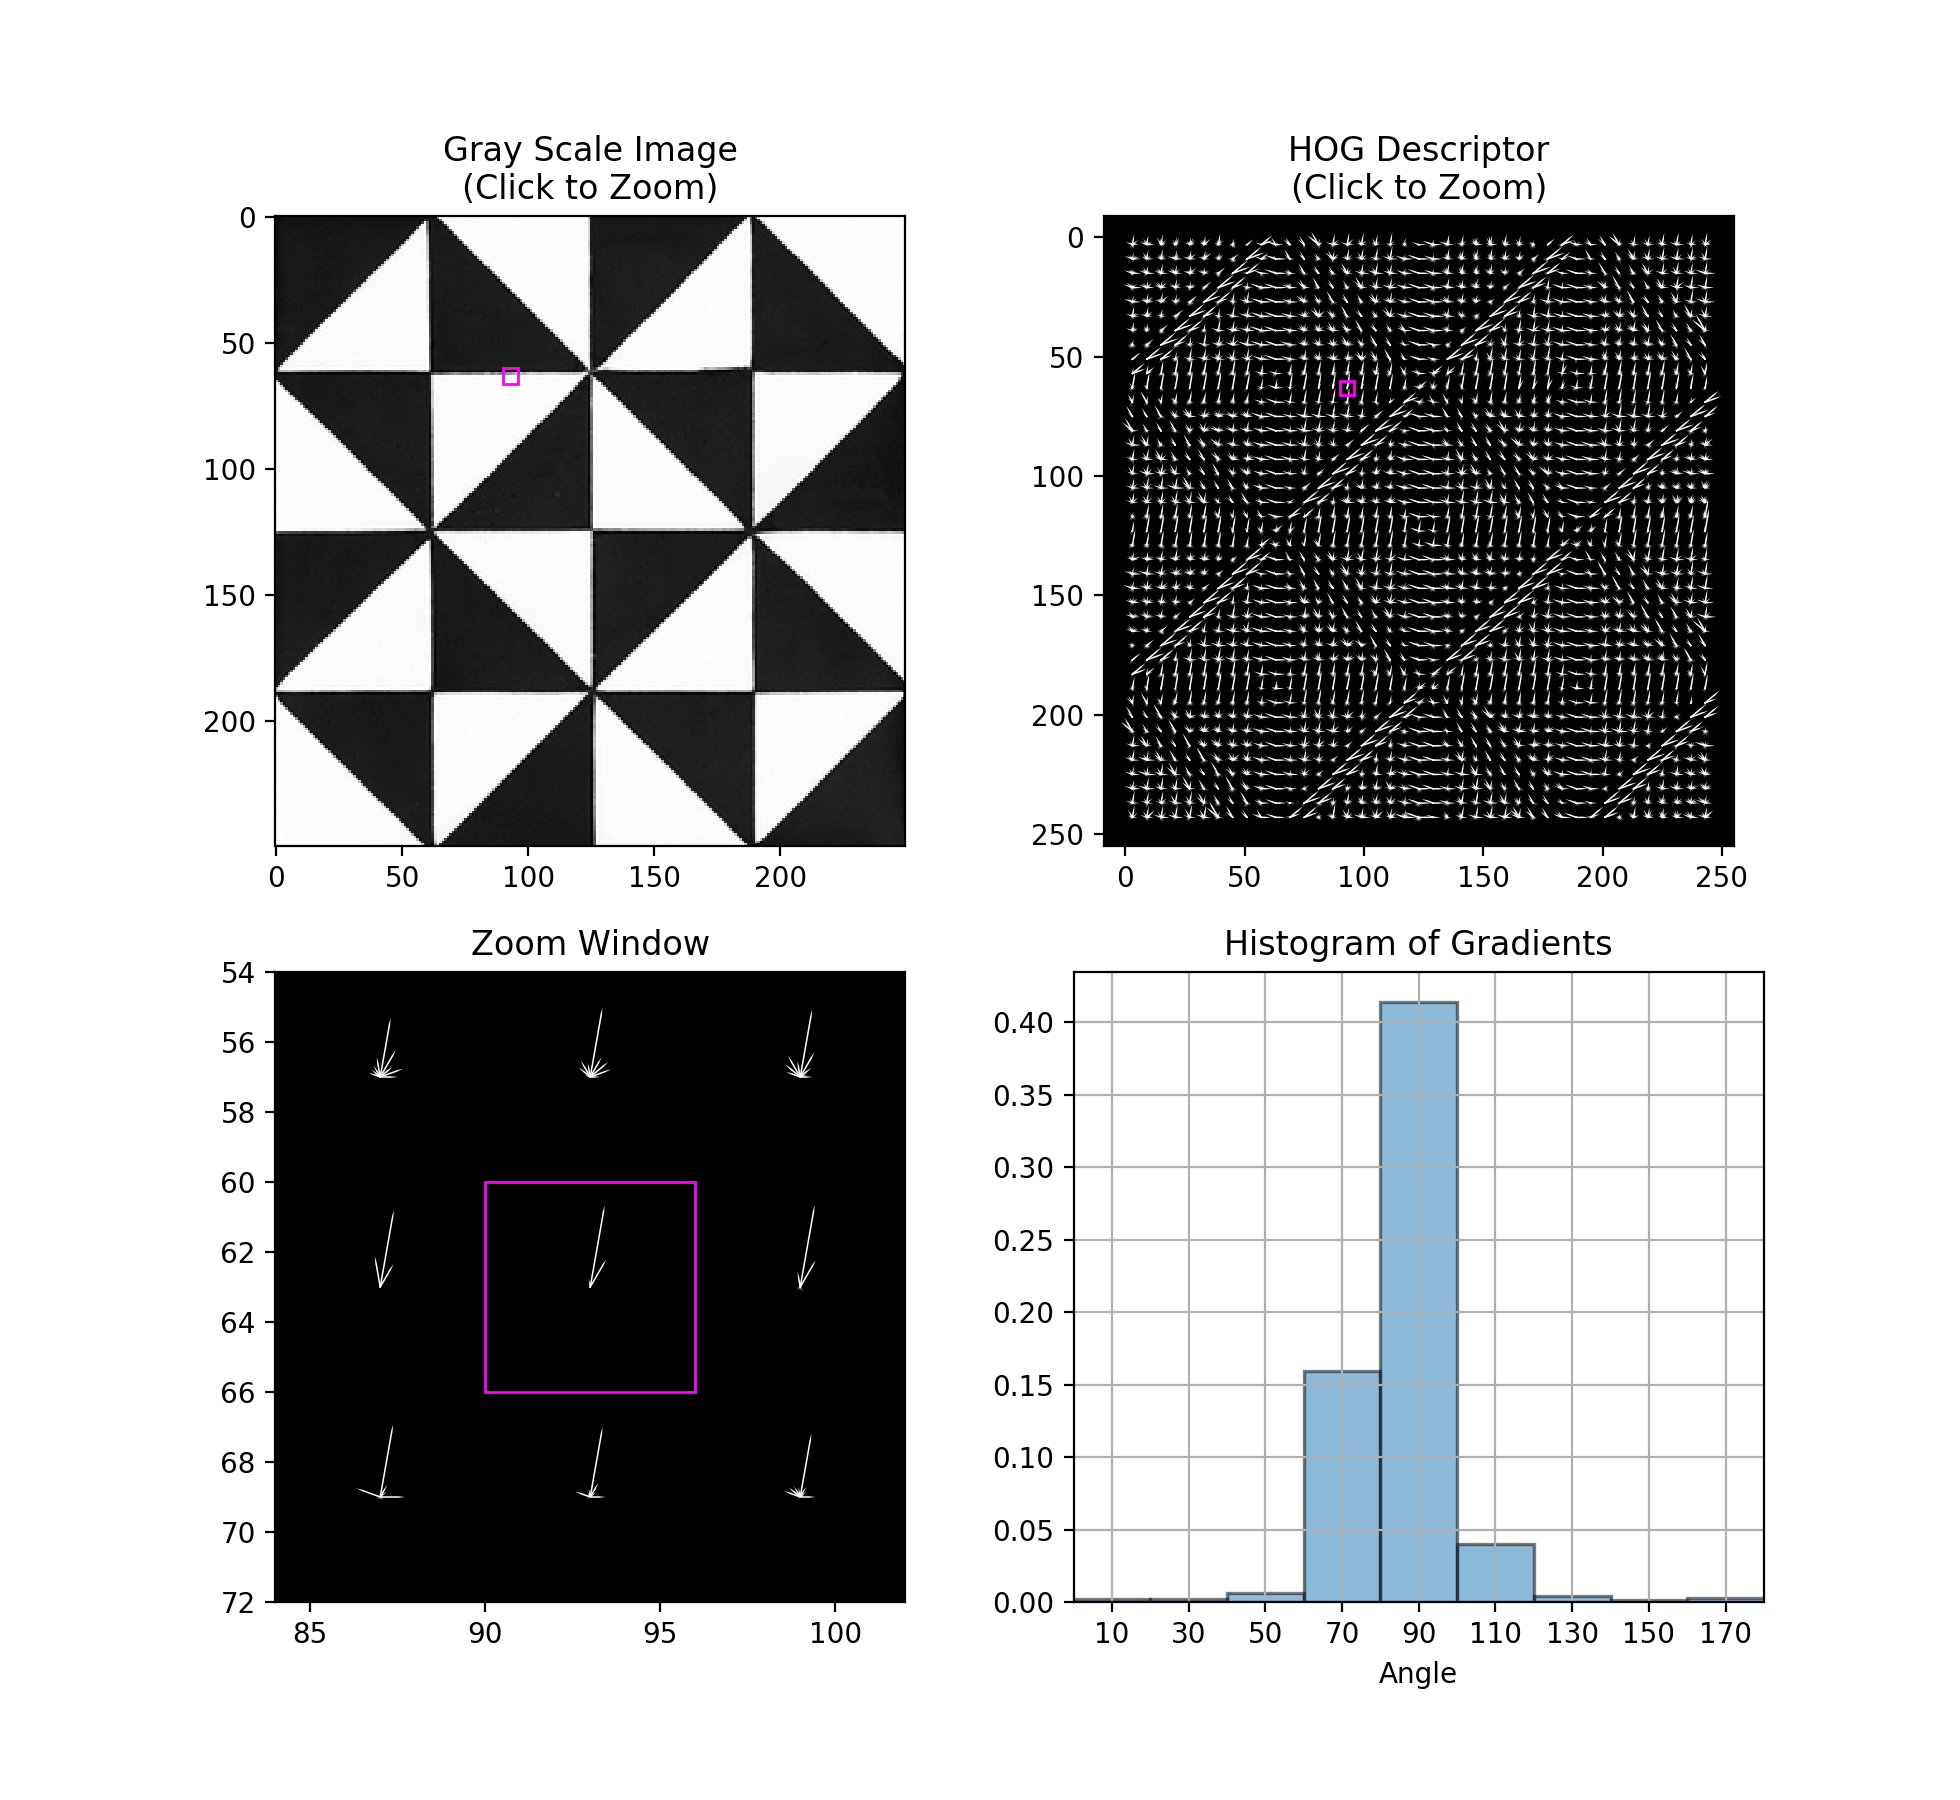

In [5]:
%matplotlib notebook

import copy
import matplotlib.patches as patches

# Set the default figure size
plt.rcParams['figure.figsize'] = [9.8, 9]

# Reshape the feature vector to [blocks_y, blocks_x, num_cells_per_block_x, num_cells_per_block_y, num_bins].
# The blocks_x and blocks_y will be transposed so that the first index (blocks_y) referes to the row number
# and the second index to the column number. This will be useful later when we plot the feature vector, so
# that the feature vector indexing matches the image indexing.
hog_descriptor_reshaped = hog_descriptor.reshape(tot_bx,
                                                 tot_by,
                                                 num_cells_per_block[0],
                                                 num_cells_per_block[1],
                                                 num_bins).transpose((1, 0, 2, 3, 4))

# Print the shape of the feature vector for reference
print('The feature vector has shape:', hog_descriptor.shape)

# Print the reshaped feature vector
print('The reshaped feature vector has shape:', hog_descriptor_reshaped.shape)

# Create an array that will hold the average gradients for each cell
ave_grad = np.zeros((y_cells, x_cells, num_bins))

# Print the shape of the ave_grad array for reference
print('The average gradient array has shape: ', ave_grad.shape) 

# Create an array that will count the number of histograms per cell
hist_counter = np.zeros((y_cells, x_cells, 1))

# Add up all the histograms for each cell and count the number of histograms per cell
for i in range (num_cells_per_block[0]):
    for j in range(num_cells_per_block[1]):
        ave_grad[i:tot_by + i,
                 j:tot_bx + j] += hog_descriptor_reshaped[:, :, i, j, :]
        
        hist_counter[i:tot_by + i,
                     j:tot_bx + j] += 1

# Calculate the average gradient for each cell
ave_grad /= hist_counter
   
# Calculate the total number of vectors we have in all the cells.
len_vecs = ave_grad.shape[0] * ave_grad.shape[1] * ave_grad.shape[2]

# Create an array that has num_bins equally spaced between 0 and 180 degress in radians.
deg = np.linspace(0, np.pi, num_bins, endpoint = False)

# Each cell will have a histogram with num_bins. For each cell, plot each bin as a vector (with its magnitude
# equal to the height of the bin in the histogram, and its angle corresponding to the bin in the histogram). 
# To do this, create rank 1 arrays that will hold the (x,y)-coordinate of all the vectors in all the cells in the
# image. Also, create the rank 1 arrays that will hold all the (U,V)-components of all the vectors in all the
# cells in the image. Create the arrays that will hold all the vector positons and components.
U = np.zeros((len_vecs))
V = np.zeros((len_vecs))
X = np.zeros((len_vecs))
Y = np.zeros((len_vecs))

# Set the counter to zero
counter = 0

# Use the cosine and sine functions to calculate the vector components (U,V) from their maginitudes. Remember the 
# cosine and sine functions take angles in radians. Calculate the vector positions and magnitudes from the
# average gradient array
for i in range(ave_grad.shape[0]):
    for j in range(ave_grad.shape[1]):
        for k in range(ave_grad.shape[2]):
            U[counter] = ave_grad[i,j,k] * np.cos(deg[k])
            V[counter] = ave_grad[i,j,k] * np.sin(deg[k])
        
            X[counter] = (cell_size[0] / 2) + (cell_size[0] * i)
            Y[counter] = (cell_size[1] / 2) + (cell_size[1] * j)
        
            counter = counter + 1

# Create the bins in degress to plot our histogram. 
angle_axis = np.linspace(0, 180, num_bins, endpoint = False)
angle_axis += ((angle_axis[1] - angle_axis[0]) / 2)

# Create a figure with 4 subplots arranged in 2 x 2
fig, ((a,b),(c,d)) = plt.subplots(2,2)

# Set the title of each subplot
a.set(title = 'Gray Scale Image\n(Click to Zoom)')
b.set(title = 'HOG Descriptor\n(Click to Zoom)')
c.set(title = 'Zoom Window', xlim = (0, 18), ylim = (0, 18), autoscale_on = False)
d.set(title = 'Histogram of Gradients')

# Plot the gray scale image
a.imshow(gray_image, cmap = 'gray')
a.set_aspect(aspect = 1)

# Plot the feature vector (HOG Descriptor)
b.quiver(Y, X, U, V, color = 'white', headwidth = 0, headlength = 0, scale_units = 'inches', scale = 5)
b.invert_yaxis()
b.set_aspect(aspect = 1)
b.set_facecolor('black')

# Define function for interactive zoom
def onpress(event):
    
    #Unless the left mouse button is pressed do nothing
    if event.button != 1:
        return
    
    # Only accept clicks for subplots a and b
    if event.inaxes in [a, b]:
        
        # Get mouse click coordinates
        x, y = event.xdata, event.ydata
        
        # Select the cell closest to the mouse click coordinates
        cell_num_x = np.uint32(x / cell_size[0])
        cell_num_y = np.uint32(y / cell_size[1])
        
        # Set the edge coordinates of the rectangle patch
        edgex = x - (x % cell_size[0])
        edgey = y - (y % cell_size[1])
        
        # Create a rectangle patch that matches the the cell selected above        
        rect = patches.Rectangle((edgex, edgey),
                                  cell_size[0], cell_size[1],
                                  linewidth = 1,
                                  edgecolor = 'magenta',
                                  facecolor='none')
        
        # A single patch can only be used in a single plot. Create copies
        # of the patch to use in the other subplots
        rect2 = copy.copy(rect)
        rect3 = copy.copy(rect)
        
        # Update all subplots
        a.clear()
        a.set(title = 'Gray Scale Image\n(Click to Zoom)')
        a.imshow(gray_image, cmap = 'gray')
        a.set_aspect(aspect = 1)
        a.add_patch(rect)

        b.clear()
        b.set(title = 'HOG Descriptor\n(Click to Zoom)')
        b.quiver(Y, X, U, V, color = 'white', headwidth = 0, headlength = 0, scale_units = 'inches', scale = 5)
        b.invert_yaxis()
        b.set_aspect(aspect = 1)
        b.set_facecolor('black')
        b.add_patch(rect2)

        c.clear()
        c.set(title = 'Zoom Window')
        c.quiver(Y, X, U, V, color = 'white', headwidth = 0, headlength = 0, scale_units = 'inches', scale = 1)
        c.set_xlim(edgex - cell_size[0], edgex + (2 * cell_size[0]))
        c.set_ylim(edgey - cell_size[1], edgey + (2 * cell_size[1]))
        c.invert_yaxis()
        c.set_aspect(aspect = 1)
        c.set_facecolor('black')
        c.add_patch(rect3)

        d.clear()
        d.set(title = 'Histogram of Gradients')
        d.grid()
        d.set_xlim(0, 180)
        d.set_xticks(angle_axis)
        d.set_xlabel('Angle')
        d.bar(angle_axis,
              ave_grad[cell_num_y, cell_num_x, :],
              180 // num_bins,
              align = 'center',
              alpha = 0.5,
              linewidth = 1.2,
              edgecolor = 'k')

        fig.canvas.draw()

# Create a connection between the figure and the mouse click
fig.canvas.mpl_connect('button_press_event', onpress)
plt.show()

# Understanding The Histograms

Let's take a look at a couple of snapshots of the above figure to see if the histograms for the selected cell make sense. Let's start looking at a cell that is inside a triangle and not near an edge:

<br>
<figure>
  <img src = "./Animations/snapshot1.png" width = "70%" style = "border: thin silver solid; padding: 1px">
      <figcaption style = "text-align:center; font-style:italic">Fig. 4. - Histograms Inside a Triangle.</figcaption>
</figure> 
<br>

In this case, since the triangle is nearly all of the same color there shouldn't be any dominant gradient in the selected cell. As we can clearly see in the Zoom Window and the histogram, this is indeed the case. We have many gradients but none of them clearly dominates over the other.

Now let’s take a look at a cell that is near a horizontal edge:

<br>
<figure>
  <img src = "./Animations/snapshot2.png" width = "70%" style = "border: thin silver solid; padding: 1px">
      <figcaption style = "text-align:center; font-style:italic">Fig. 5. - Histograms Near a Horizontal Edge.</figcaption>
</figure> 
<br>

Remember that edges are areas of an image where the intensity changes abruptly. In these cases, we will have a high intensity gradient in some particular direction. This is exactly what we see in the corresponding histogram and Zoom Window for the selected cell.  In the Zoom Window, we can see that the dominant gradient is pointing up, almost at 90 degrees, since that’s the direction in which there is a sharp change in intensity. Therefore, we should expect to see the 90-degree bin in the histogram to dominate strongly over the others. This is in fact what we see. 

Now let’s take a look at a cell that is near a vertical edge:

<br>
<figure>
  <img src = "./Animations/snapshot3.png" width = "70%" style = "border: thin silver solid; padding: 1px">
      <figcaption style = "text-align:center; font-style:italic">Fig. 6. - Histograms Near a Vertical Edge.</figcaption>
</figure> 
<br>

In this case we expect the dominant gradient in the cell to be horizontal, close to 180 degrees, since that’s the direction in which there is a sharp change in intensity. Therefore, we should expect to see the 170-degree bin in the histogram to dominate strongly over the others. This is what we see in the histogram but we also see that there is another dominant gradient in the cell, namely the one in the 10-degree bin. The reason for this, is because the HOG algorithm is using unsigned gradients, which means 0 degrees and 180 degrees are considered the same. Therefore, when the histograms are being created, angles between 160 and 180 degrees, contribute proportionally to both the 10-degree bin and the 170-degree bin. This results in there being two dominant gradients in the cell near the vertical edge instead of just one. 

To conclude let’s take a look at a cell that is near a diagonal edge.

<br>
<figure>
  <img src = "./Animations/snapshot4.png" width = "70%" style = "border: thin silver solid; padding: 1px">
      <figcaption style = "text-align:center; font-style:italic">Fig. 7. - Histograms Near a Diagonal Edge.</figcaption>
</figure> 
<br>

To understand what we are seeing, let’s first remember that gradients have an *x*-component, and a *y*-component, just like vectors. Therefore, the resulting orientation of a gradient is going to be given by the vector sum of its components. For this reason, on vertical edges the gradients are horizontal, because they only have an x-component, as we saw in Figure 4. While on horizontal edges the gradients are vertical, because they only have a y-component, as we saw in Figure 3. Consequently, on diagonal edges, the gradients are also going to be diagonal because both the *x* and *y* components are non-zero.  Since the diagonal edges in the image are close to 45 degrees, we should expect to see a dominant gradient orientation in the 50-degree bin. This is in fact what we see in the histogram but, just like in Figure 4., we see there are two dominant gradients instead of just one. The reason for this is that when the histograms are being created, angles that are near the boundaries of bins, contribute proportionally to the adjacent bins.  For example, a gradient with an angle of 40 degrees, is right in the middle of the 30-degree and 50-degree bin. Therefore, the magnitude of the gradient is split evenly into the 30-degree and 50-degree bin. This results in there being two dominant gradients in the cell near the diagonal edge instead of just one.

Now that you know how HOG is implemented, in the workspace you will find a notebook named *Examples*. In there, you will be able set your own paramters for the HOG descriptor for various images. Have fun!